# 3. Diffusion Model Training 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import numpy as np
import json
import math

# Set the random seed (for replicability)
seed = 20777980
random.seed(seed)
np.random.seed(seed)

def determine_max_seq_len(data, max_length='max_length'):
    """Calculate the max sequence length dynamically if 'max_length' is used as argument."""
    if max_length == 'max_length':
        MAX_LENGTH = max(len(dp["tokens"]) for dp in data)
    else:
        MAX_LENGTH = max_length
    return MAX_LENGTH

def setup_device():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    return model

def load_model(model,filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    
    device = setup_device()
    model.to(device)
    return model,device

def load_dataset(file_path):
    """Load the dataset from a JSON file."""
    with open(file_path, 'r') as file:
        dataset = [json.loads(line) for line in file]
    return dataset

def save_JSON(data,filename):
    with open(filename, 'w') as f:
        json.dump(data, f)
    return

def load_JSON(filename):
    """Load a JSON file."""
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

# Define a Noise Schedule using a Cosine schedule (commonly used in DDPMs)
class CosineNoiseSchedule:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.alphas = torch.cos(torch.linspace(0, math.pi/2, timesteps))**2
        self.betas = 1.0 - self.alphas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)  # Cumulative product of alphas

    def get_alpha(self, t):
        return self.alphas[t]

    def get_beta(self, t):
        return self.betas[t]

    def get_variance(self, t):
        return self.get_beta(t) * (1 - self.get_alpha(t))
    
    def get_alpha_bar(self, t):
        return self.alpha_bar[t]

# Define the Diffusion Model (symbolic regression version)
class DiffusionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=4, num_timesteps=1000):
        super(DiffusionModel, self).__init__()
        self.vocab_size = vocab_size
        self.num_timesteps = num_timesteps
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.transformer = nn.Transformer(d_model=embedding_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers)
        self.fc_out = nn.Linear(embedding_dim, vocab_size)  # For token prediction (symbolic generation)
    
    def forward(self, tokens):
        embedded_tokens = self.embedding(tokens)
        embedded_tokens = embedded_tokens.transpose(0, 1)  # Change to (seq_len, batch_size, embedding_dim)
        transformer_output = self.transformer(embedded_tokens, embedded_tokens)
        logits = self.fc_out(transformer_output)
        return logits
    
    def add_noise(self, token_ids, t, schedule):
        """Add noise to the token sequence during the forward diffusion process."""
        noisy_token_ids = token_ids.clone()
        noise_level = schedule.get_variance(t)

        # Apply noise as per variance (e.g., Gaussian noise)
        noise = torch.normal(mean=0, std=noise_level, size=noisy_token_ids.shape)
        noisy_token_ids = noisy_token_ids + noise.long()  # Convert to integer token IDs

        # Ensure the token IDs are within bounds
        vocab_size = self.vocab_size
        noisy_token_ids = torch.clamp(noisy_token_ids, 0, vocab_size - 1)
        return noisy_token_ids

    def reverse_diffusion(self, noisy_input, schedule):
        """Apply reverse diffusion to denoise the sequence."""
        x_t = noisy_input
        for t in reversed(range(self.num_timesteps)):
            predicted_noise = self.forward(x_t)  # Predict noise at timestep t
            alpha_t = schedule.get_alpha(t)
            beta_t = schedule.get_beta(t)
            alpha_bar_t = schedule.get_alpha_bar(t)
            # Reverse the noise process
            x_t = (x_t - beta_t * predicted_noise)/alpha_bar_t
        return x_t

# Loss function for training: Predict the noise at each timestep
def denoising_loss(predicted_noise, noisy_input, clean_input):
    """Loss function for symbolic regression."""
    return nn.MSELoss()(predicted_noise, clean_input - noisy_input)

# Dataset for symbolic regression
class SymbolicRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, max_seq_len, noise_schedule):
        self.data = data
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.noise_schedule = noise_schedule

    def add_noise(self, token_ids, t, schedule):
        """Add noise to the token sequence during the forward diffusion process."""
        # Convert token_ids from list to a PyTorch tensor
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        noisy_token_ids = token_ids.clone()  # Now .clone() will work on the tensor
        noise_level = schedule.get_variance(t)  # Get noise level

        if isinstance(noise_level, torch.Tensor):
            noise_level = noise_level.item()
        
        # Apply Gaussian noise
        noise = torch.normal(mean=0, std=noise_level, size=noisy_token_ids.shape)
        noisy_token_ids = noisy_token_ids + noise.long()  # Convert to integer token IDs

        # Ensure the token IDs are within bounds
        vocab_size = len(self.vocab)
        noisy_token_ids = torch.clamp(noisy_token_ids, 0, vocab_size - 1)
        
        return noisy_token_ids

    def __getitem__(self, idx):
        data_point = self.data[idx]
        temp_token_ids = data_point['tokens']
        filtered_token_ids = [token for token in temp_token_ids if token != '<PAD>']

        # Pad the token sequence if necessary
        pad_token_id = self.vocab.get('<PAD>', 5)
        token_ids = filtered_token_ids + [pad_token_id]*(self.max_seq_len - len(filtered_token_ids))

        # Convert to tensor (this step is now safe as token_ids contains integers)
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        t = torch.randint(0, 1000, (1,))  # Sample a random timestep
        noisy_token_ids = self.add_noise(token_ids, t, self.noise_schedule)

        # Return noisy token IDs and clean token IDs for loss computation
        return noisy_token_ids, token_ids
    
    def __len__(self):
        """Return the length of the dataset."""
        return len(self.data)
    
# Training loop for the diffusion model
def train_diffusion_model(model,train_loader,val_loader,num_epochs=10,patience_num_epochs=3):
    device = setup_device()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    schedule = CosineNoiseSchedule(timesteps=1000)
    
    best_val_loss = np.inf
    num_epochs_without_improvement = 0
    early_stopping = False
    
    performance_metrics_DICT = {
        "epoch_list": [],
        "train_loss_list": [],
        "val_loss_list": []    
    }
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch_idx, (noisy_tokens, target_tokens) in enumerate(train_loader):
            optimizer.zero_grad()

            # Randomly pick a timestep for each batch
            t = random.randint(0, model.num_timesteps - 1)

            # Add noise at the forward diffusion process
            noisy_batch = torch.stack([model.add_noise(seq, t, schedule) for seq in noisy_tokens])
            
            # Forward pass through the model (predict denoised expression at timestep t)
            logits = model(noisy_batch)  # Predict logits (denoised tokens)

            # Flatten the logits and target tokens for loss computation
            logits = logits.view(-1, logits.size(-1))  # Flatten the logits (seq_len * batch_size, vocab_size)
            target_tokens = target_tokens.view(-1)  # Flatten the target tokens (seq_len * batch_size)

            # Loss computation using CrossEntropyLoss (you can switch to another loss if needed)
            loss = nn.CrossEntropyLoss()(logits, target_tokens)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        train_loss = total_loss/len(train_loader)
        performance_metrics_DICT['train_loss_list'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy_tokens, target_tokens in val_loader:
                logits = model(noisy_tokens)  # Predict logits (denoised tokens)
                
                # Flatten logits and target tokens for loss computation
                logits = logits.view(-1, logits.size(-1))  # Flatten (seq_len * batch_size, vocab_size)
                target_tokens = target_tokens.view(-1)  # Flatten target tokens (seq_len * batch_size)
                
                # CrossEntropyLoss for token prediction
                loss = nn.CrossEntropyLoss()(logits, target_tokens)
                val_loss += loss.item()
        
        val_loss = val_loss/len(val_loader)
        performance_metrics_DICT['val_loss_list'].append(val_loss)

        performance_metrics_DICT['epoch_list'].append(epoch+1)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(),"Data/best_diffusion_model.pt")
            save_JSON(performance_metrics_DICT,'Data/diffusion_performance_metrics_DICT.json')
            num_epochs_without_improvement = 0
            best_model_weights = model.state_dict()
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f'Early stopping occurred at epoch {epoch + 1}')
            early_stopping = True
            break

        if early_stopping:
            model.load_state_dict(best_model_weights)
            print("Selected the best model weights from early stopping.")
    
    if early_stopping == False:
        torch.save(model.state_dict(),"Data/best_diffusion_model.pt")
        save_JSON(performance_metrics_DICT,'Data/diffusion_performance_metrics_DICT.json')
    return model,performance_metrics_DICT

# Sample generation
def sample(model, schedule, vocab, batch_size=16):
    # Start with random noise
    noisy_input = torch.randint(0, len(vocab), (batch_size, model.num_timesteps))
    denoised_output = model.reverse_diffusion(noisy_input, schedule)
    return denoised_output

In [ ]:
dataset = load_dataset('Data/preprocessed_data.json')
vocab = load_JSON("Data/vocab.json")

MAX_LENGTH = determine_max_seq_len(dataset)  # Determine the max length dynamically

schedule = CosineNoiseSchedule(timesteps=1000)

# Now pass the schedule when initializing SymbolicRegressionDataset
full_dataset = SymbolicRegressionDataset(dataset, vocab, MAX_LENGTH, schedule)

# First, perform the split on the raw dataset
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Initialize the SymbolicRegressionDataset with the schedule for each subset
train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=False)

# Initialize model, optimizer, and loss function
model = DiffusionModel(vocab_size=len(vocab), embedding_dim=128, hidden_dim=256, num_layers=4, num_timesteps=1000)

# Train the model
model,performance_metrics_DICT = train_diffusion_model(model,train_loader,val_loader,num_epochs=10,patience_num_epochs=3)

C:\Users\matth\AppData\Local\Temp\ipykernel_26940\2993062493.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_ids = torch.tensor(token_ids, dtype=torch.long)


Epoch 1/10, Train Loss: 2.1797847151756287, Val Loss: 2.1314515935050116
Epoch 2/10, Train Loss: 2.151776986462729, Val Loss: 2.143797232045068


: 

# Plotting Results

In [ ]:
import matplotlib.pyplot as plt

#Visualize the train and validation loss
def plot_train_valid(model_name,performance_metrics_DICT):
    plt.figure();
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['train_loss_list'], label=f'Train Loss', color='blue', linestyle='--', marker='o');
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['val_loss_list'], label=f'Validation Loss', color='green', linestyle='-', marker='x');
    plt.title(f'{model_name} Training and Validation Loss');
    plt.xlabel('Epochs');
    plt.ylabel('Loss');
    plt.legend();
    plt.grid();
    plt.xlim(0,max(performance_metrics_DICT['epoch_list'])+1);
    return

In [5]:
dataset = load_dataset('Data/preprocessed_data.json')
vocab = load_JSON("Data/vocab.json")

MAX_LENGTH = determine_max_seq_len(dataset)  # Determine the max length dynamically

schedule = CosineNoiseSchedule(timesteps=1000)

# Now pass the schedule when initializing SymbolicRegressionDataset
full_dataset = SymbolicRegressionDataset(dataset, vocab, MAX_LENGTH, schedule)

# First, perform the split on the raw dataset
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Initialize the SymbolicRegressionDataset with the schedule for each subset
train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=False)

c:\Users\matth\OneDrive - University of Waterloo\Documents\Python Files\Environments\STAT940_Final_Project_VENV\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\matth\AppData\Local\Temp\ipykernel_26940\2097671235.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via th

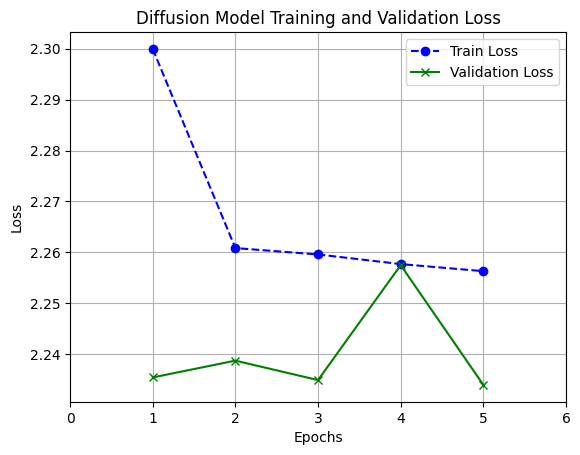

In [7]:
model = DiffusionModel(vocab_size=len(vocab), embedding_dim=128, hidden_dim=256, num_layers=4, num_timesteps=1000)

performance_metrics_DICT = load_JSON('Data/diffusion_performance_metrics_DICT.json')

model,device = load_model(model,"Data/best_diffusion_model.pt")

model_name = 'Diffusion Model'

plot_train_valid(model_name,performance_metrics_DICT)

# Evaluation

In [8]:
import sympy as sp

# Convert token sequence to mathematical expression string
def tokens_to_expression(tokens, vocab):
    """Convert a list of token IDs into a string representation of a mathematical expression."""
    # Reverse the vocab dictionary to map IDs back to their token strings
    reverse_vocab = {v: k for k, v in vocab.items()}
    
    # Decode the token sequence to the corresponding expression
    expression = ''.join([reverse_vocab[t] for t in tokens.squeeze(0).tolist() if reverse_vocab[t] != '<PAD>'])
    
    return expression

# Evaluate expression against inputs using SymPy
def evaluate_expression_sympy(expression, inputs):
    """Evaluate the mathematical expression using sympy for symbolic evaluation."""
    # Create sympy symbols for each input variable (e.g., x0, x1, etc.)
    symbols = {f"x{i}": sp.symbols(f"x{i}") for i in range(len(inputs))}
    
    try:
        # Parse the expression as a sympy expression
        parsed_expression = sp.sympify(expression)
        
        # Substitute the input values into the expression
        substituted_expr = parsed_expression.subs(symbols)
        
        # Evaluate the substituted expression
        result = substituted_expr.evalf()  # Use evalf() to compute the numerical value
        
        return result
    except Exception as e:
        print(f"Error evaluating expression '{expression}': {e}")
        return None

# Evaluate the model on the dataset
def evaluate_model_on_dataset(model, dataset, dataset_SR, vocab, schedule):
    """Evaluate the model on the dataset by generating symbolic expressions and comparing them to actual outputs."""
    model.eval()
    total_mse = 0
    total_mae = 0
    num_examples = len(dataset)
    
    for data_point, data_point_SR in zip(dataset,dataset_SR):
        # Extract the token sequence (post-denoising)
        noisy_tokens = data_point_SR[0]  # Noisy tokens (output of the model)
        true_output = data_point_SR[1]  # Ground truth output (target tokens)

        # Decode the noisy token sequence to the corresponding expression
        noisy_expression = tokens_to_expression(noisy_tokens, vocab)
        true_expression = tokens_to_expression(true_output, vocab)

        print(f"noisy_expression: {noisy_expression}, true_expression = {true_expression}")
        
        # For simplicity, assuming inputs are a predefined set of values (e.g., {'x0': 1, 'x1': 2, ...})
        # Alternatively, you could replace this with actual input values if they exist in your dataset
        inputs = data_point['inputs']
        outputs = data_point['output']
        
        # Evaluate the expression on the input values
        predicted_output = evaluate_expression_sympy(noisy_expression, inputs)
        
        if predicted_output is not None:
            # Compute the Mean Squared Error (MSE) and Mean Absolute Error (MAE) for prediction accuracy
            mse = (predicted_output - true_output.item()) ** 2
            mae = abs(predicted_output - true_output.item())
            
            total_mse += mse
            total_mae += mae
    
    # Compute average metrics
    avg_mse = total_mse/num_examples
    avg_mae = total_mae/num_examples
    
    print(f"Average MSE: {avg_mse}")
    print(f"Average MAE: {avg_mae}")
    
    return avg_mse, avg_mae

avg_mse, avg_mae = evaluate_model_on_dataset(model, test_dataset, test_dataset_SR, vocab, schedule)

print(f"Test MSE: {avg_mse}")
print(f"Test MAE: {avg_mae}")


C:\Users\matth\AppData\Local\Temp\ipykernel_26940\2097671235.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_ids = torch.tensor(token_ids, dtype=torch.long)


noisy_expression: +x0^+*x2^E.EE., true_expression = *x0^+*x1
Error evaluating expression '+x0^+*x2^E.EE.': Sympify of expression 'could not parse '+x0^+*x2^E.EE.'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)
noisy_expression: .*x0^+.*x0*x1+.*x1^, true_expression = .*x0^+.*x0*x1+.*x1^
Error evaluating expression '.*x0^+.*x0*x1+.*x1^': Sympify of expression 'could not parse '.*x0^+.*x0*x1+.*x1^'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)
noisy_expression: *x4+(exp(x2)+)., true_expression = E*x4*(cos(x2)+)
Error evaluating expression '*x4+(exp(x2)+).': Sympify of expression 'could not parse '*x4+(exp(x2)+).'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)
noisy_expression: sin((x0^+x0)^), true_expression = sin((x0^+x0)^)
Error evaluating expression 'sin((x0^+x0)^)': Sympify of expression 'could not parse 'sin((x0^+x0)^)'' failed, because of exception bei

RuntimeError: a Tensor with 17 elements cannot be converted to Scalar